# Analysis of a Dynamical Systems : Lotka - Volterra

see http://scipy-cookbook.readthedocs.io/ (ODE section) for more

In [1]:
from scipy.integrate import odeint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimize

# For those of you interested.... 
# There is a notebook backend way to render figures....

# %matplotlib notebook
# # using notebook backend to render figures
# # see here for more tips:
# # - https://stackoverflow.com/questions/41125690/matplotlib-notebook-showing-a-blank-histogram
# # - https://stackoverflow.com/questions/43445103/inline-animations-in-jupyter




%matplotlib inline
# this line renders the images as png 
# - works well for static plots (recommended then)
# - does not work with animations (will only show last frame)

In [2]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", RuntimeWarning)
# Just to make it cleaner I do not print some of the warnings 
# Runtime Warning necessary to the nonlinear solver


# Reminder : Lotka - Volterra

In [3]:
def LotkaVolterra(state,t):
    x = state[0]
    y = state[1]
    
    alpha = 0.1
    beta =  0.1
    sigma = 0.1
    gamma = 0.1
    
    xd = x*(alpha - beta*y)
    yd = -y*(gamma - sigma*x)
    return [xd,yd]


# 1 - System Analysis
<br> 
The straightforward way you will have been taught

In [4]:
# Definition of parameters (outside)
a = 1.
b = 0.1
c = 1.5
d = 0.75

t = np.linspace(0, 15,  1000)  

# ------------------------------------------------------------------------

def dX_dt(X, t=0):
    """ growth rate of fox and rabbit populations. """
    return np.array([ a*X[0] -   b*X[0]*X[1] ,
                     -c*X[1] + d*b*X[0]*X[1] ])


def d2X_dt2(X, t=0):
    """ Jacobian matrix evaluated in X. """
    return np.array([[a -b*X[1],   -b*X[0]     ],
                  [b*d*X[1] ,   -c +b*d*X[0]] ])

# ------------------------------------------------------------------------

# Steady Points of System
X_f0 = np.array([     0. ,  0.])
X_f1 = np.array([ c/(d*b), a/b])
# LV is great in the sense you can easily solve the equations for the steady points


# Jacobian at Steady Points
A_f0 = d2X_dt2(X_f0) 
A_f1 = d2X_dt2(X_f1) 

# Corresponding Eigenvalues
Eig_f0 = np.linalg.eigvals(A_f0)
Eig_f1 = np.linalg.eigvals(A_f1)

# 2 Steady Points of the System
print('First Point:{}'.format(X_f0))
print('Is it a Steady Point:{}'.format(all(dX_dt(X_f0) == np.zeros(2) )))
print('The Jacobian at that point is \n {}'.format(A_f0))
print('Its Eigenvalues ares \n {}'.format(Eig_f0))
print('--------------------------------------')
print('Second Point:{}'.format(X_f1))
print('Is it a Steady Point:{}'.format(all(dX_dt(X_f1) == np.zeros(2) )))
print('The Jacobian at that point is \n {}'.format(A_f1))
print('Its Eigenvalues ares \n {}'.format(Eig_f1))

First Point:[0. 0.]
Is it a Steady Point:True
The Jacobian at that point is 
 [[ 1.  -0. ]
 [ 0.  -1.5]]
Its Eigenvalues ares 
 [ 1.  -1.5]
--------------------------------------
Second Point:[20. 10.]
Is it a Steady Point:True
The Jacobian at that point is 
 [[ 0.   -2.  ]
 [ 0.75  0.  ]]
Its Eigenvalues ares 
 [0.+1.22474487j 0.-1.22474487j]


# 2 - Let's do it a bit differently
<br> 
Q: What if I was laxy or steady points were hard to find (they are in general)
A: Then we solve the steady state equations numerically!

## We need to talk about seeding...

In [5]:
# Rather than having the steady points given to us
# We are going to find them ie solve the equation dX_dt(x)=0

# We need to use a numerical solver
# https://docs.scipy.org/doc/scipy/reference/optimize.html
# https://docs.scipy.org/doc/scipy/reference/optimize.nonlin.html

# Examples : 
seed = [20,15]
x = optimize.broyden1(dX_dt, seed, f_tol=1e-20)
print('Algorithm with seed {} converges to {}'.format(seed,x))

seed = [10,10]
y = optimize.broyden1(dX_dt, seed, f_tol=1e-20)
print('Algorithm with seed {} converges to {}'.format(seed,y))

# So the seed is important.....

Algorithm with seed [20, 15] converges to [20. 10.]
Algorithm with seed [10, 10] converges to [-1.97215226e-31 -4.93038066e-32]


## Grid Search
<br>
Coarse, brutal but works...

In [6]:
# We therefore need to do a grid search 
# say over [0,25]*[0,25] (the flow indicates we do not need to go further)
intervalX = np.linspace(1, 25, 25) 
intervalY = np.linspace(1, 25, 26) 

solutions = [{"solution":tuple(optimize.broyden1(dX_dt, [x,y], f_tol=1e-20)),"seed":(x,y)}
             for x in intervalX for y in intervalY]

print(f"Output to Search (Unfiltered)\n------------------------------------------------")
for i,solution in enumerate(solutions[0:100]): 
    print(f"Run {i} - Seed : {solution['seed']} - Solution : {solution['solution']}")    

# You can make the output prettier but it is not the point here

Output to Search (Unfiltered)
------------------------------------------------
Run 0 - Seed : (1.0, 1.0) - Solution : (-1.4187807813620962e-21, 1.3087000139890829e-22)
Run 1 - Seed : (1.0, 1.96) - Solution : (5.724402934732672e-27, -2.6000156263329426e-28)
Run 2 - Seed : (1.0, 2.92) - Solution : (8.876333086433998e-25, -9.244632516744233e-27)
Run 3 - Seed : (1.0, 3.88) - Solution : (4.919490653715801e-22, 4.896708927997334e-24)
Run 4 - Seed : (1.0, 4.84) - Solution : (5.530726210154222e-23, 1.3809942380727813e-24)
Run 5 - Seed : (1.0, 5.8) - Solution : (1.4967214925752444e-24, 5.612752206587751e-26)
Run 6 - Seed : (1.0, 6.76) - Solution : (1.1603174210074085e-26, 5.7188357934871775e-28)
Run 7 - Seed : (1.0, 7.72) - Solution : (-1.1891602682251732e-28, -7.408528883854066e-30)
Run 8 - Seed : (1.0, 8.68) - Solution : (2.743752278574471e-22, 2.198221265804277e-23)
Run 9 - Seed : (1.0, 9.64) - Solution : (2.421901654049207e-26, 2.7288209362894927e-27)
Run 10 - Seed : (1.0, 10.6) - Solution 

### The grid search returns way more different candidates that we expected!!!
1 - we convert to a set of solutions in order to remove the duplicates if there are any
NB: if you use set, you need to convert the arrays/lists to tuples (hashable objects)

2 - of course the various streams will not have converged exactly to the same solutions 
we can see a lot of spurious steady points around (0,0), which is to be expected as the point is not stable
=> first step :  round the values returned / the solvers !!!!


In [7]:
# Step 1 : round the solutions

solutions = [tuple(np.around(optimize.broyden1(dX_dt, [x,y], f_tol=1e-20),decimals=10))
                        for x in intervalX for y in intervalY]
# 10 decimals should do

#Step 2 : Convert the list into a set
solutions = list(set(solutions))

print(f"Output to Search (Filtered)\n------------------------------------------------")
for i,solution in enumerate(solutions[0:100]): 
    print(f"Solution {i+1} - - Solution : {solution}")   
    
# Much more civilised


Output to Search (Filtered)
------------------------------------------------
Solution 1 - - Solution : (20.0, 10.0)
Solution 2 - - Solution : (-0.0, 0.0)


# 3 - For your Eyes Only
<br>
Q: What if I was lazy OR hopeless at derivating even simple functions?
Or more generally, what if I wanted to automate the whole process?

A: we use symbolic calculus...

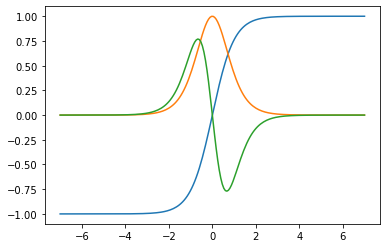

In [8]:
# We need to install a library called autograd (from github)
# https://github.com/HIPS/autograd

import autograd
import autograd.numpy as np                 # important it seems....
from autograd import elementwise_grad as egrad  # for functions that vectorize over inputs

def tanh(x):                 # Define a function
    y = np.exp(-2.0 * x)
    return (1.0 - y) / (1.0 + y)

x = np.linspace(-7, 7, 200)
plt.plot(x, tanh(x),
          x, egrad(tanh)(x),                                     # first  derivative
          x, egrad(egrad(tanh))(x))                              # second  derivative
plt.show()

Why is it interesting?
Because it means we need not calculate the Jacobian explicitly (which can be tricky in high dimensions)

## Method 1
After : https://stackoverflow.com/questions/54488875/improve-performance-of-autograd-jacobian
Basically, we compute the matrix one column at a time

In [9]:
import autograd.numpy as np
from autograd.differential_operators import make_jvp_reversemode

def LV(coord):
    X,Y = coord
    """ growth rate of fox and rabbit populations. """
    return np.array([ a*X -   b*X*Y ,
                     -c*Y + d*b*X*Y ])

# We want more than columsn, we want the whole matrix...
def jacobianAtPoint(f,point):
    gradient_at_mle = make_jvp_reversemode(f)(point)
    J = np.zeros((2,2))
    for i,basis in enumerate([np.array([1, 0]), np.array([0, 1])]):
        col_of_jacobian = gradient_at_mle(basis)
        J[:,i] = col_of_jacobian
    return J

all_unique_solutions = tuple(set(solutions))
jacobians_at_steady_points = (jacobianAtPoint(LV,np.array(x,dtype="float")) for x in all_unique_solutions)
# NB: extremeley important to make sure x is cast properly (autograd is not tolerant)

for x,j in zip(all_unique_solutions,jacobians_at_steady_points):
    print('At steady point {}'.format(x))
    print('The Jacobian is \n {}'.format(j))
    print('Its Eigenvalues ares \n {}'.format(np.linalg.eigvals(j)))    
    print('-------------------------')

At steady point (20.0, 10.0)
The Jacobian is 
 [[ 0.00000000e+00 -2.00000000e+00]
 [ 7.50000000e-01  2.22044605e-16]]
Its Eigenvalues ares 
 [1.11022302e-16+1.22474487j 1.11022302e-16-1.22474487j]
-------------------------
At steady point (-0.0, 0.0)
The Jacobian is 
 [[ 1.   0. ]
 [ 0.  -1.5]]
Its Eigenvalues ares 
 [ 1.  -1.5]
-------------------------


## Method 2
Use the Jacobian module of Autograd
(Allegedly slower... for NN)

In [10]:
import autograd.numpy as np
from autograd import jacobian


jacobians_at_steady_points = (jacobian(LV)(np.array(x,dtype="float")) for x in all_unique_solutions)
# NB: extremeley important to make sure x is cast properly (autograd is not tolerant)

for x,j in zip(all_unique_solutions,jacobians_at_steady_points):
    print('At steady point {}'.format(x))
    print('The Jacobian is \n {}'.format(j))
    print('Its Eigenvalues ares \n {}'.format(np.linalg.eigvals(j)))    
    print('-------------------------')

At steady point (20.0, 10.0)
The Jacobian is 
 [[ 0.00000000e+00 -2.00000000e+00]
 [ 7.50000000e-01  2.22044605e-16]]
Its Eigenvalues ares 
 [1.11022302e-16+1.22474487j 1.11022302e-16-1.22474487j]
-------------------------
At steady point (-0.0, 0.0)
The Jacobian is 
 [[ 1.   0. ]
 [ 0.  -1.5]]
Its Eigenvalues ares 
 [ 1.  -1.5]
-------------------------
